Purpose: Problem set 4 code

Created: Nico Rotundo 2024-12-05

Import packages and data, and define useful functions

In [ ]:
'''--------------------------------------------------------------------------------------------------------------------------------------
Initializing packages and setting display options
--------------------------------------------------------------------------------------------------------------------------------------'''

# Import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from colorama import Fore, Style
import matplotlib.pyplot as plt
from scipy import stats


# Define ANSI escape codes for the orange color
orange = '\033[38;5;214m'  # Orange color (ANSI code 214)
reset = '\033[0m'          # Reset to default color

## Adjust display options
# Show all columns
pd.set_option('display.max_columns', None)  

# Automatically adjust to screen width
pd.set_option('display.width', 1000)          

# Set maximum column width to 50 (or adjust as needed)
pd.set_option('display.max_colwidth', 50)  

'''--------------------------------------------------------------------------------------------------------------------------------------
Importing data
--------------------------------------------------------------------------------------------------------------------------------------'''

# Load the .out file into a DataFrame
data = pd.read_csv("/Users/nicorotundo/Library/CloudStorage/Box-Box/econ_240a/data/Brazil_1996PNAD.out", sep='\s+', na_values=[''])

'''--------------------------------------------------------------------------------------------------------------------------------------
    Mimics Stata's `tab` command for a given column in a DataFrame.
 
    Parameters:
        data (pd.DataFrame): The dataset.
        column (str): The name of the column to tabulate.
    
    Returns:
        pd.DataFrame: A DataFrame with Value, Frequency, Percentage, and Cumulative Percentage.
--------------------------------------------------------------------------------------------------------------------------------------'''

def tabulate_variable(data, column):
    
   # Calculate value counts and normalize for percentages
    value_counts = data[column].value_counts(dropna=False)

    # Directly create a DataFrame
    tab_output = pd.DataFrame({
        'Value': value_counts.index,
        'Frequency': value_counts.values
    })

    # Sort the results by the Value column in ascending order
    tab_output = tab_output.sort_values(by='Value', ascending=True)
    
    # Add percentage column
    tab_output['Percentage'] = (tab_output['Frequency'] / tab_output['Frequency'].sum()) * 100

    # Add cumulative percentage column
    tab_output['Cumulative Percentage'] = tab_output['Percentage'].cumsum()

    # Display the variable name
    print(f"\nTabulation for variable: {column}\n")

    # Print output and suppress index here
    print(tab_output.to_string(index=False))  


[a]: Compute the least squares fit of ln(MONTHLY_EARNINGS) onto a constant YRSSCH, AgeInDays, and AgeInDays squared. Construct a 95 percent confidence interval for the coefficient on YrsSch. Write your own Python function to complete this computation. Your function should also construct and return a variance-covariance estimate which can be used to con- struct asymptotic standard errors. Compare your results – point estimates and standard errors – with those of the StatsModels OLS implementation.

In [2]:
'''--------------------------------------------------------------------------------------------------------------------------------------
 Define OLS function
--------------------------------------------------------------------------------------------------------------------------------------'''

def ols(data, y_var, x_vars):
    # Extract dependent and independent variables
    Y = data[y_var].values
    X = data[x_vars].values
    
    # Add a column of ones to X to account for the intercept
    X = np.column_stack((np.ones(X.shape[0]), X))
    
    # Calculate OLS estimates
    X_transpose = X.T
    beta = np.linalg.inv(X_transpose @ X) @ X_transpose @ Y
    
    # Calculate residuals
    residuals = Y - X @ beta
    
    # Calculate variance of residuals
    n = len(Y)
    k = X.shape[1]
    sigma_squared = (residuals.T @ residuals) / (n - k)
    
    # Calculate HC1 standard errors
    h = residuals ** 2 / (1 - np.diag(X @ np.linalg.inv(X_transpose @ X) @ X_transpose))
    var_cov_matrix = np.linalg.inv(X_transpose @ X) @ (X_transpose @ np.diag(h) @ X) @ np.linalg.inv(X_transpose @ X)
    standard_errors = np.sqrt(np.diag(var_cov_matrix))

    # Construct 95% confidence intervals
    confidence_intervals = []
    for i in range(len(beta)):
        ci_lower = beta[i] - 1.96 * standard_errors[i]
        ci_upper = beta[i] + 1.96 * standard_errors[i]
        confidence_intervals.append((ci_lower, ci_upper))
    
    return beta, var_cov_matrix, confidence_intervals


'''--------------------------------------------------------------------------------------------------------------------------------------
Define additional variables and impose estimation sample restrictions
--------------------------------------------------------------------------------------------------------------------------------------'''

# Filter data for those who have positive MONTHLY_EARNINGS and are between 20-60 years old
estimation_sample = data[(data['MONTHLY_EARNINGS'] > 0) & (data['AgeInDays'] >= 20) & (data['AgeInDays'] <= 60)].copy()

# Take log of MONTHLY_EARNINGS
estimation_sample['ln(MONTHLY_EARNINGS)'] = np.log(estimation_sample['MONTHLY_EARNINGS'])

# Generate AgeInDays squared
estimation_sample['AgeInDays_squared'] = estimation_sample['AgeInDays'] ** 2

'''--------------------------------------------------------------------------------------------------------------------------------------
Run regression using the OLS function and construct asymptotic standard errors
--------------------------------------------------------------------------------------------------------------------------------------'''
# Run custom OLS function and store values 
beta, var_cov_matrix, confidence_intervals = ols(estimation_sample, 'ln(MONTHLY_EARNINGS)', ['YRSSCH', 'AgeInDays', 'AgeInDays_squared'])

# Store standard errors
standard_errors = np.sqrt(np.diag(var_cov_matrix))

'''--------------------------------------------------------------------------------------------------------------------------------------
Construct and print confidence interval around YrsSch coefficient
--------------------------------------------------------------------------------------------------------------------------------------'''
# Print confidence interval for YrsSch coefficient
ci_lower, ci_upper = confidence_intervals[1]
print(f"\n{orange}Confidence interval for YrsSch coefficient: ({ci_lower:.4g}, {ci_upper:.4g}){reset}")

'''--------------------------------------------------------------------------------------------------------------------------------------
Run ols using the statsmodels package
--------------------------------------------------------------------------------------------------------------------------------------'''
# Run OLS using the statsmodels package
ols_stats_model = sm.OLS(estimation_sample['ln(MONTHLY_EARNINGS)'], sm.add_constant(estimation_sample[['YRSSCH', 'AgeInDays', 'AgeInDays_squared']])).fit(cov_type='HC1')

# Print statsmodels OLS results
print("\nStatsmodels OLS Results:")
print(ols_stats_model.summary())

'''--------------------------------------------------------------------------------------------------------------------------------------
Compare point estimates and standard errors between custom and statspackage OLS and print results
--------------------------------------------------------------------------------------------------------------------------------------'''
# Formatting
print(f"\n{orange}Custom OLS Results:{reset}")
print("-" * 80)
print("-" * 80)
print(f"{orange}{'Variable':<20} {'Coefficient':>15} {'Standard Error':>15} {'95% CI Lower':>15} {'95% CI Upper':>15}{reset}")
print("-" * 80)

# Print custom OLS result for each coefficient in a table 
for i in range(len(beta)):
  ci_lower, ci_upper = confidence_intervals[i]
  print(f"\n{orange}{['const', 'YRSSCH', 'AgeInDays', 'AgeInDays_squared'][i]:<20} {beta[i]:>15.4f} {standard_errors[i]:>15.4f} {ci_lower:>15.4f} {ci_upper:>15.4f}{reset}")

# Print white space
print("\n")

# Print statsmodels OLS result for each coefficient in a table
print(f"\n{orange}Statsmodels OLS Results:{reset}")
print(f"{orange}{ols_stats_model.summary().tables[1]}{reset}")



Confidence interval for YrsSch coefficient: (0.144, 0.1472)

Statsmodels OLS Results:
                             OLS Regression Results                             
Dep. Variable:     ln(MONTHLY_EARNINGS)   R-squared:                       0.420
Model:                              OLS   Adj. R-squared:                  0.420
Method:                   Least Squares   F-statistic:                 1.246e+04
Date:                  Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                          20:11:18   Log-Likelihood:                -64169.
No. Observations:                 55551   AIC:                         1.283e+05
Df Residuals:                     55547   BIC:                         1.284e+05
Df Model:                             3                                         
Covariance Type:                    HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------

[b]: Compute the least squares fit of ln(MONTHLY_EARNINGS) onto a constant YRSSCH, AgeInDays, AgeInDayssquared,Dad_NoSchool_c, Dad_1stPrim_c, Dad_2ndPrim_c, Dad_Sec_c, Mom_NoSchool_c, Mom_1stPrim_c, Mom_2ndPrim_c, and Mom_Sec_c. Compare the resulting coefficient on YRSSCH with that in part [a] above. Provide an explanation for any differences found.

    - The resulting coefficient on YRSSCH is .1370 (.0009) in this specification, compared to .1456 (.0010) in the specification in part [a]. The coefficient is likely smaller in this specification, because the other variables in the model (parent schooling) are likely correlated with MONTHLY EARNINGS and YRSSCH i.e., omitted variable bias. 
    
    - In other words, in specification [a], YRSSCH is capturing the effect of parent schooling on MONTHLY_EARNINGS as well as the effect of own years of schooling itself. Once we add these other variables, the association of earnings and YRSSCH is smaller. 

In [3]:
# Least squares fit of ln(MONTHLY_EARNINGS) onto a constant YRSSCH, AgeInDays, AgeInDays_squared, Dad_NoSchool_c, Dad_1stPrim_c, Dad_2ndPrim_c, Dad_Sec_c, Mom_NoSchool_c, Mom_1stPrim_c, Mom_2ndPrim_c, and Mom_Sec_c
beta, var_cov_matrix, confidence_intervals = ols(estimation_sample, 'ln(MONTHLY_EARNINGS)', ['YRSSCH', 'AgeInDays', 'AgeInDays_squared', 'Father_NoSchool', 'Father_Complete1stPrimary',
                                                                                            'Father_Complete2ndPrimary', 'Father_CompleteSecondary', 'Mother_NoSchool', 'Mother_Complete1stPrimary', 
                                                                                            'Mother_Complete2ndPrimary', 'Mother_CompleteSecondary'])
# Store standard errors
standard_errors = np.sqrt(np.diag(var_cov_matrix))

# Formatting
print(f"\n{orange}Custom OLS Results:{reset}")
print("-" * 80)
print("-" * 80)
print(f"{orange}{'Variable':<20} {'Coefficient':>15} {'Standard Error':>15} {'95% CI Lower':>15} {'95% CI Upper':>15}{reset}")
print("-" * 80)

# Print custom OLS result for each coefficient in a table 
for i in range(len(beta)):
  ci_lower, ci_upper = confidence_intervals[i]
  print(f"\n{orange}{['const', 'YRSSCH', 'AgeInDays', 'AgeInDays_squared', 'Father_NoSchool', 'Father_Complete1stPrimary','Father_Complete2ndPrimary', 'Father_CompleteSecondary', 'Mother_NoSchool', 'Mother_Complete1stPrimary', 'Mother_Complete2ndPrimary', 'Mother_CompleteSecondary'][i]:<20} {beta[i]:>15.4f} {standard_errors[i]:>15.4f} {ci_lower:>15.4f} {ci_upper:>15.4f}{reset}")

# Print white space
print("\n")


Custom OLS Results:
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Variable                 Coefficient  Standard Error    95% CI Lower    95% CI Upper
--------------------------------------------------------------------------------

const                         3.0214          0.0419          2.9393          3.1035

YRSSCH                        0.1370          0.0009          0.1352          0.1388

AgeInDays                     0.0917          0.0024          0.0870          0.0963

AgeInDays_squared            -0.0009          0.0000         -0.0010         -0.0009

Father_NoSchool              -0.0529          0.0092         -0.0709         -0.0348

Father_Complete1stPrimary          0.0802          0.0112          0.0583          0.1021

Father_Complete2ndPrimary         -0.0457          0.0192         -0.0834         -0.0080

Father_CompleteSecondary         -0.00

[c]: Show how you can compute the coefficient on YRSSCH in [b] by a least squares fit of ln(MONTHLY_EARNINGS) on a single variable. Describe this variable, construct, it and calculate the least squares fit to check your answer. 

    - First, regress YRSSCH on the other control variables, obtaining a vector of coefficients i.e., the auxiliary regression.

    - Second, define the residuals from the auxillary regression as the `single variable` variable noted in the question.

    - Then, we can recover the coefficient of YRSSCH in part [b] by regressing ln(MONTHLY_EARNINGS) on the single variable.

    - The above is an application of the Frisch-Waugh-Lovell theorem.

In [4]:
# Least squares fit YRSSCH onto AgeInDays, AgeInDays_squared, Dad_NoSchool_c, Dad_1stPrim_c, Dad_2ndPrim_c, Dad_Sec_c, Mom_NoSchool_c, Mom_1stPrim_c, Mom_2ndPrim_c, and Mom_Sec_c
beta, var_cov_matrix, confidence_intervals = ols(estimation_sample, 'YRSSCH', ['AgeInDays', 'AgeInDays_squared', 'Father_NoSchool', 'Father_Complete1stPrimary',
                                                                                            'Father_Complete2ndPrimary', 'Father_CompleteSecondary', 'Mother_NoSchool', 'Mother_Complete1stPrimary', 
                                                                                            'Mother_Complete2ndPrimary', 'Mother_CompleteSecondary'])

# Define residuals
estimation_sample['residuals'] = estimation_sample['YRSSCH'] - (beta[0] + beta[1] * estimation_sample['AgeInDays'] + beta[2] * estimation_sample['AgeInDays_squared'] + beta[3] * estimation_sample['Father_NoSchool'] + beta[4] * estimation_sample['Father_Complete1stPrimary'] + beta[5] * estimation_sample['Father_Complete2ndPrimary'] + beta[6] * estimation_sample['Father_CompleteSecondary'] + beta[7] * estimation_sample['Mother_NoSchool'] + beta[8] * estimation_sample['Mother_Complete1stPrimary'] + beta[9] * estimation_sample['Mother_Complete2ndPrimary'] + beta[10] * estimation_sample['Mother_CompleteSecondary'])

# Regress ln(Monthly Earnings) onto residuals
beta, var_cov_matrix, confidence_intervals = ols(estimation_sample, 'ln(MONTHLY_EARNINGS)', ['residuals'])

# Print coefficient on the residual of above regression
print(f"\n{orange}Coefficient on the residual of the regression of YRSSCH on AgeInDays, AgeInDays_squared, Dad_NoSchool_c, Dad_1stPrim_c, Dad_2ndPrim_c, Dad_Sec_c, Mom_NoSchool_c, Mom_1stPrim_c, Mom_2ndPrim_c, and Mom_Sec_c: {beta[1]:.4f}{reset}")



Coefficient on the residual of the regression of YRSSCH on AgeInDays, AgeInDays_squared, Dad_NoSchool_c, Dad_1stPrim_c, Dad_2ndPrim_c, Dad_Sec_c, Mom_NoSchool_c, Mom_1stPrim_c, Mom_2ndPrim_c, and Mom_Sec_c: 0.1370


[d] Using the Bayes’ Bootstrap to approximate a posterior distribution of the coefficient on YRSSCH in the linear predictors described in parts [a] and [b]. How do these posterior distributions compare with their estimated asymptotic sampling distributions?

    - The posterior and asymptotic distributions are similar, as seen in the figures below.

Part [a] - Mean coefficient on YRSSCH: 0.14560322521448968
Part [a] - 95% confidence interval for YRSSCH: (np.float64(0.14397424419684948), np.float64(0.14718901010937402))
Part [b] - Mean coefficient on YRSSCH: 0.13699860743756753
Part [b] - 95% confidence interval for YRSSCH: (np.float64(0.1351518335685408), np.float64(0.1388426058942828))


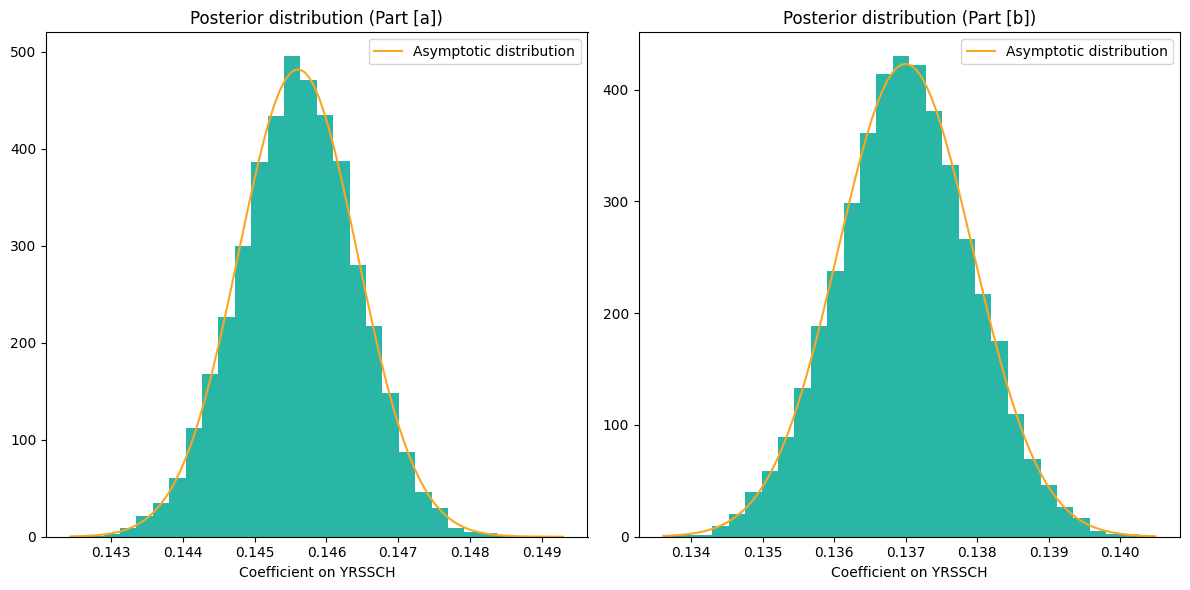

In [15]:
def bayes_bootstrap(data, y_var, x_vars, num_samples):
    n = len(data)
    bootstrap_coefs = []

    X = data[x_vars].values
    Y = data[y_var].values
    X = np.column_stack((np.ones(X.shape[0]), X))  # Add intercept

    for _ in range(num_samples):
        # Generate Dirichlet weights
        dirichlet_weights = np.random.dirichlet(np.ones(n))
        
        # Weighted OLS regression
        W = np.sqrt(dirichlet_weights)[:, None]
        X_weighted = W * X
        Y_weighted = W.flatten() * Y
        
        # Fit weighted OLS model
        ols_model_boot = sm.OLS(Y_weighted, X_weighted).fit(cov_type='HC1')
        
        # Store the coefficient of YRSSCH
        bootstrap_coefs.append(ols_model_boot.params[1])  # Coefficient on YRSSCH
    
    return np.array(bootstrap_coefs)

# Example usage
# Assuming 'estimation_sample' is a pandas DataFrame with the relevant columns
y_var = 'ln(MONTHLY_EARNINGS)'
x_vars_a = ['YRSSCH', 'AgeInDays', 'AgeInDays_squared']
x_vars_b = ['YRSSCH', 'AgeInDays', 'AgeInDays_squared', 'Father_NoSchool', 'Father_Complete1stPrimary',
            'Father_Complete2ndPrimary', 'Father_CompleteSecondary', 'Mother_NoSchool', 'Mother_Complete1stPrimary', 
            'Mother_Complete2ndPrimary', 'Mother_CompleteSecondary']
n_bootstrap = 10000

# Apply Bayes' Bootstrap to the linear predictors described in part [a]
bootstrap_coefs_a = bayes_bootstrap(estimation_sample, y_var, x_vars_a, num_samples=n_bootstrap)

# Apply Bayes' Bootstrap to the linear predictors described in part [b]
bootstrap_coefs_b = bayes_bootstrap(estimation_sample, y_var, x_vars_b, num_samples=n_bootstrap)

# Compute posterior summaries for part [a]
mean_yrssch_a = np.mean(bootstrap_coefs_a)
lower_bound_yrssch_a = np.percentile(bootstrap_coefs_a, 2.5)
upper_bound_yrssch_a = np.percentile(bootstrap_coefs_a, 97.5)

print("Part [a] - Mean coefficient on YRSSCH:", mean_yrssch_a)
print("Part [a] - 95% confidence interval for YRSSCH:", (lower_bound_yrssch_a, upper_bound_yrssch_a))

# Compute posterior summaries for part [b]
mean_yrssch_b = np.mean(bootstrap_coefs_b)
lower_bound_yrssch_b = np.percentile(bootstrap_coefs_b, 2.5)
upper_bound_yrssch_b = np.percentile(bootstrap_coefs_b, 97.5)

print("Part [b] - Mean coefficient on YRSSCH:", mean_yrssch_b)
print("Part [b] - 95% confidence interval for YRSSCH:", (lower_bound_yrssch_b, upper_bound_yrssch_b))

# Plot the posterior distributions
plt.figure(figsize=(12, 6))

# Part [a]
plt.subplot(1, 2, 1)
coef_a = bootstrap_coefs_a
plt.hist(coef_a, bins=30, density=True, color=(41/255, 182/255, 164/255))
mu_a, sigma_a = np.mean(coef_a), np.std(coef_a)
x_a = np.linspace(min(coef_a), max(coef_a), 100)
y_a = stats.norm.pdf(x_a, mu_a, sigma_a)
plt.plot(x_a, y_a, color=(250/255, 165/255, 35/255))
plt.legend(["Asymptotic distribution"])
plt.title("Posterior distribution (Part [a])")
plt.xlabel("Coefficient on YRSSCH")

# Part [b]
plt.subplot(1, 2, 2)
coef_b = bootstrap_coefs_b
plt.hist(coef_b, bins=30, density=True, color=(41/255, 182/255, 164/255))
mu_b, sigma_b = np.mean(coef_b), np.std(coef_b)
x_b = np.linspace(min(coef_b), max(coef_b), 100)
y_b = stats.norm.pdf(x_b, mu_b, sigma_b)
plt.plot(x_b, y_b, color=(250/255, 165/255, 35/255))
plt.legend(["Asymptotic distribution"])
plt.title("Posterior distribution (Part [b])")
plt.xlabel("Coefficient on YRSSCH")

plt.tight_layout()
plt.show()